In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
import json
import argparse
import torch
from tqdm import tqdm
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from trainer import Trainer
from utils import Logger
from utils import util
from utils import torchsummary
from utils import viewTraining
import importlib
import math
import torchvision
print("Modules loaded")

importlib.reload(module_data) #load recent changes to data_loaders.py
importlib.reload(module_arch)
importlib.reload(module_loss)
importlib.reload(util)
importlib.reload(viewTraining)
print("Reload complete")

print("GPUs available: " + str(torch.cuda.device_count()))

Modules loaded
Reload complete
GPUs available: 1


In [4]:
resplit_data = False
if resplit_data:
    os.system('python3 utils/splitDataFolder.py -r "data/GroundTruth_052219/" -c "data/GroundTruth_052219/Label_1.csv" -s 0.15')

In [5]:
#This function gets the parameters from the config.json file 
def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])

def main(config, resume):
    train_logger = Logger() #uses entries to store training performance metrics

    # setup data_loader instances
    data_loader = get_instance(module_data, 'data_loader', config) #looks in data_loader/data_loaders.py for 'MNISTDataLoader'
    print("Total number of training images = " + str(data_loader.dataset.data_len))
    valid_data_loader = data_loader.split_validation() #allocate some images as validation

    # build model architecture
    model = get_instance(module_arch, 'arch', config) #looks in the model/model.py for 'MnistModel', as specified by config
    print(model)
    torchsummary.summary(model, (1,28,28))
    
    if torch.cuda.is_available():
        print("Using GPU: " + torch.cuda.get_device_name(0))
    else:
        print("Using CPU to train")
    
    normalized = False
    util.visualizeBatch(data_loader, normalized)
    
    # get function handles of loss and metrics
    loss = getattr(module_loss, config['loss']) #looks in model/loss.py for 'nll_loss'
    metrics = [getattr(module_metric, met) for met in config['metrics']] #get all the metrics in model/metrics.py - default is accuracy and top 3 accuracy

    # build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
    trainable_params = filter(lambda p: p.requires_grad, model.parameters()) #Number of training params
    optimizer = get_instance(torch.optim, 'optimizer', config, trainable_params)
    lr_scheduler = get_instance(torch.optim.lr_scheduler, 'lr_scheduler', config, optimizer)

    trainer = Trainer(model, loss, metrics, optimizer,
                      resume=resume, #choose a previous epoch to start training from
                      config=config,
                      data_loader=data_loader,
                      valid_data_loader=valid_data_loader,
                      lr_scheduler=lr_scheduler,
                      train_logger=train_logger)

    trainer.train()


In [6]:
config_file = 'config_groundTruth.json'


# load config file
with open(config_file) as handle:
    config = json.load(handle)
# setting path to save trained models and log files
path = os.path.join(config['trainer']['save_dir'], config['name'])

Total number of training images = 515


/home/awoloshuk/KPMP/CellTemplate/model/model.py:132: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight.data)
/home/awoloshuk/KPMP/CellTemplate/model/model.py:138: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight.data)


heatmapModel(
  (layer): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=12544, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linea

Train Epoch: 1 [0/438 (0%)] Loss: 0.775962
Train Epoch: 1 [160/438 (36%)] Loss: 2.885201
Train Epoch: 1 [320/438 (71%)] Loss: 1.672662
    my_metric      : 0.5048701298701299
    val_loss       : 2.069317579269409
    epoch          : 1
    loss           : 6.604645805699485
    val_my_metric  : 0.5801282051282052
Saving checkpoint: saved/GroundTruth_cellData/0530_210510/checkpoint-epoch1.pth ...
Saving current best: model_best.pth ...
Train Epoch: 2 [0/438 (0%)] Loss: 1.181207
Train Epoch: 2 [160/438 (36%)] Loss: 3.144875
Train Epoch: 2 [320/438 (71%)] Loss: 1.354010
    my_metric      : 0.6215503246753247
    val_loss       : 0.9054727156956991
    epoch          : 2
    loss           : 1.4194905630179815
    val_my_metric  : 0.4254807692307692
Saving checkpoint: saved/GroundTruth_cellData/0530_210510/checkpoint-epoch2.pth ...
Saving current best: model_best.pth ...
Train Epoch: 3 [0/438 (0%)] Loss: 0.782592
Train Epoch: 3 [160/438 (36%)] Loss: 1.132847
Train Epoch: 3 [320/438 (71%)

    epoch          : 23
    loss           : 0.5039275458880833
    val_my_metric  : 0.6586538461538461
Train Epoch: 24 [0/438 (0%)] Loss: 0.528790
Train Epoch: 24 [160/438 (36%)] Loss: 0.487462
Train Epoch: 24 [320/438 (71%)] Loss: 0.421669
    my_metric      : 0.7796266233766234
    val_loss       : 0.5070497691631317
    epoch          : 24
    loss           : 0.47978836723736357
    val_my_metric  : 0.719551282051282
Train Epoch: 25 [0/438 (0%)] Loss: 0.468932
Train Epoch: 25 [160/438 (36%)] Loss: 0.590576
Train Epoch: 25 [320/438 (71%)] Loss: 0.558641
    my_metric      : 0.7660308441558442
    val_loss       : 0.530410885810852
    epoch          : 25
    loss           : 0.47511567175388336
    val_my_metric  : 0.6842948717948718
Train Epoch: 26 [0/438 (0%)] Loss: 0.419035
Train Epoch: 26 [160/438 (36%)] Loss: 0.480219
Train Epoch: 26 [320/438 (71%)] Loss: 0.545908
    my_metric      : 0.7640016233766234
    val_loss       : 0.5002447466055552
    epoch          : 26
    loss  

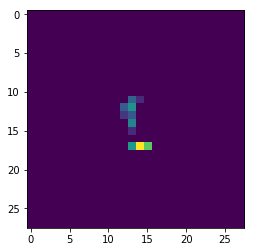

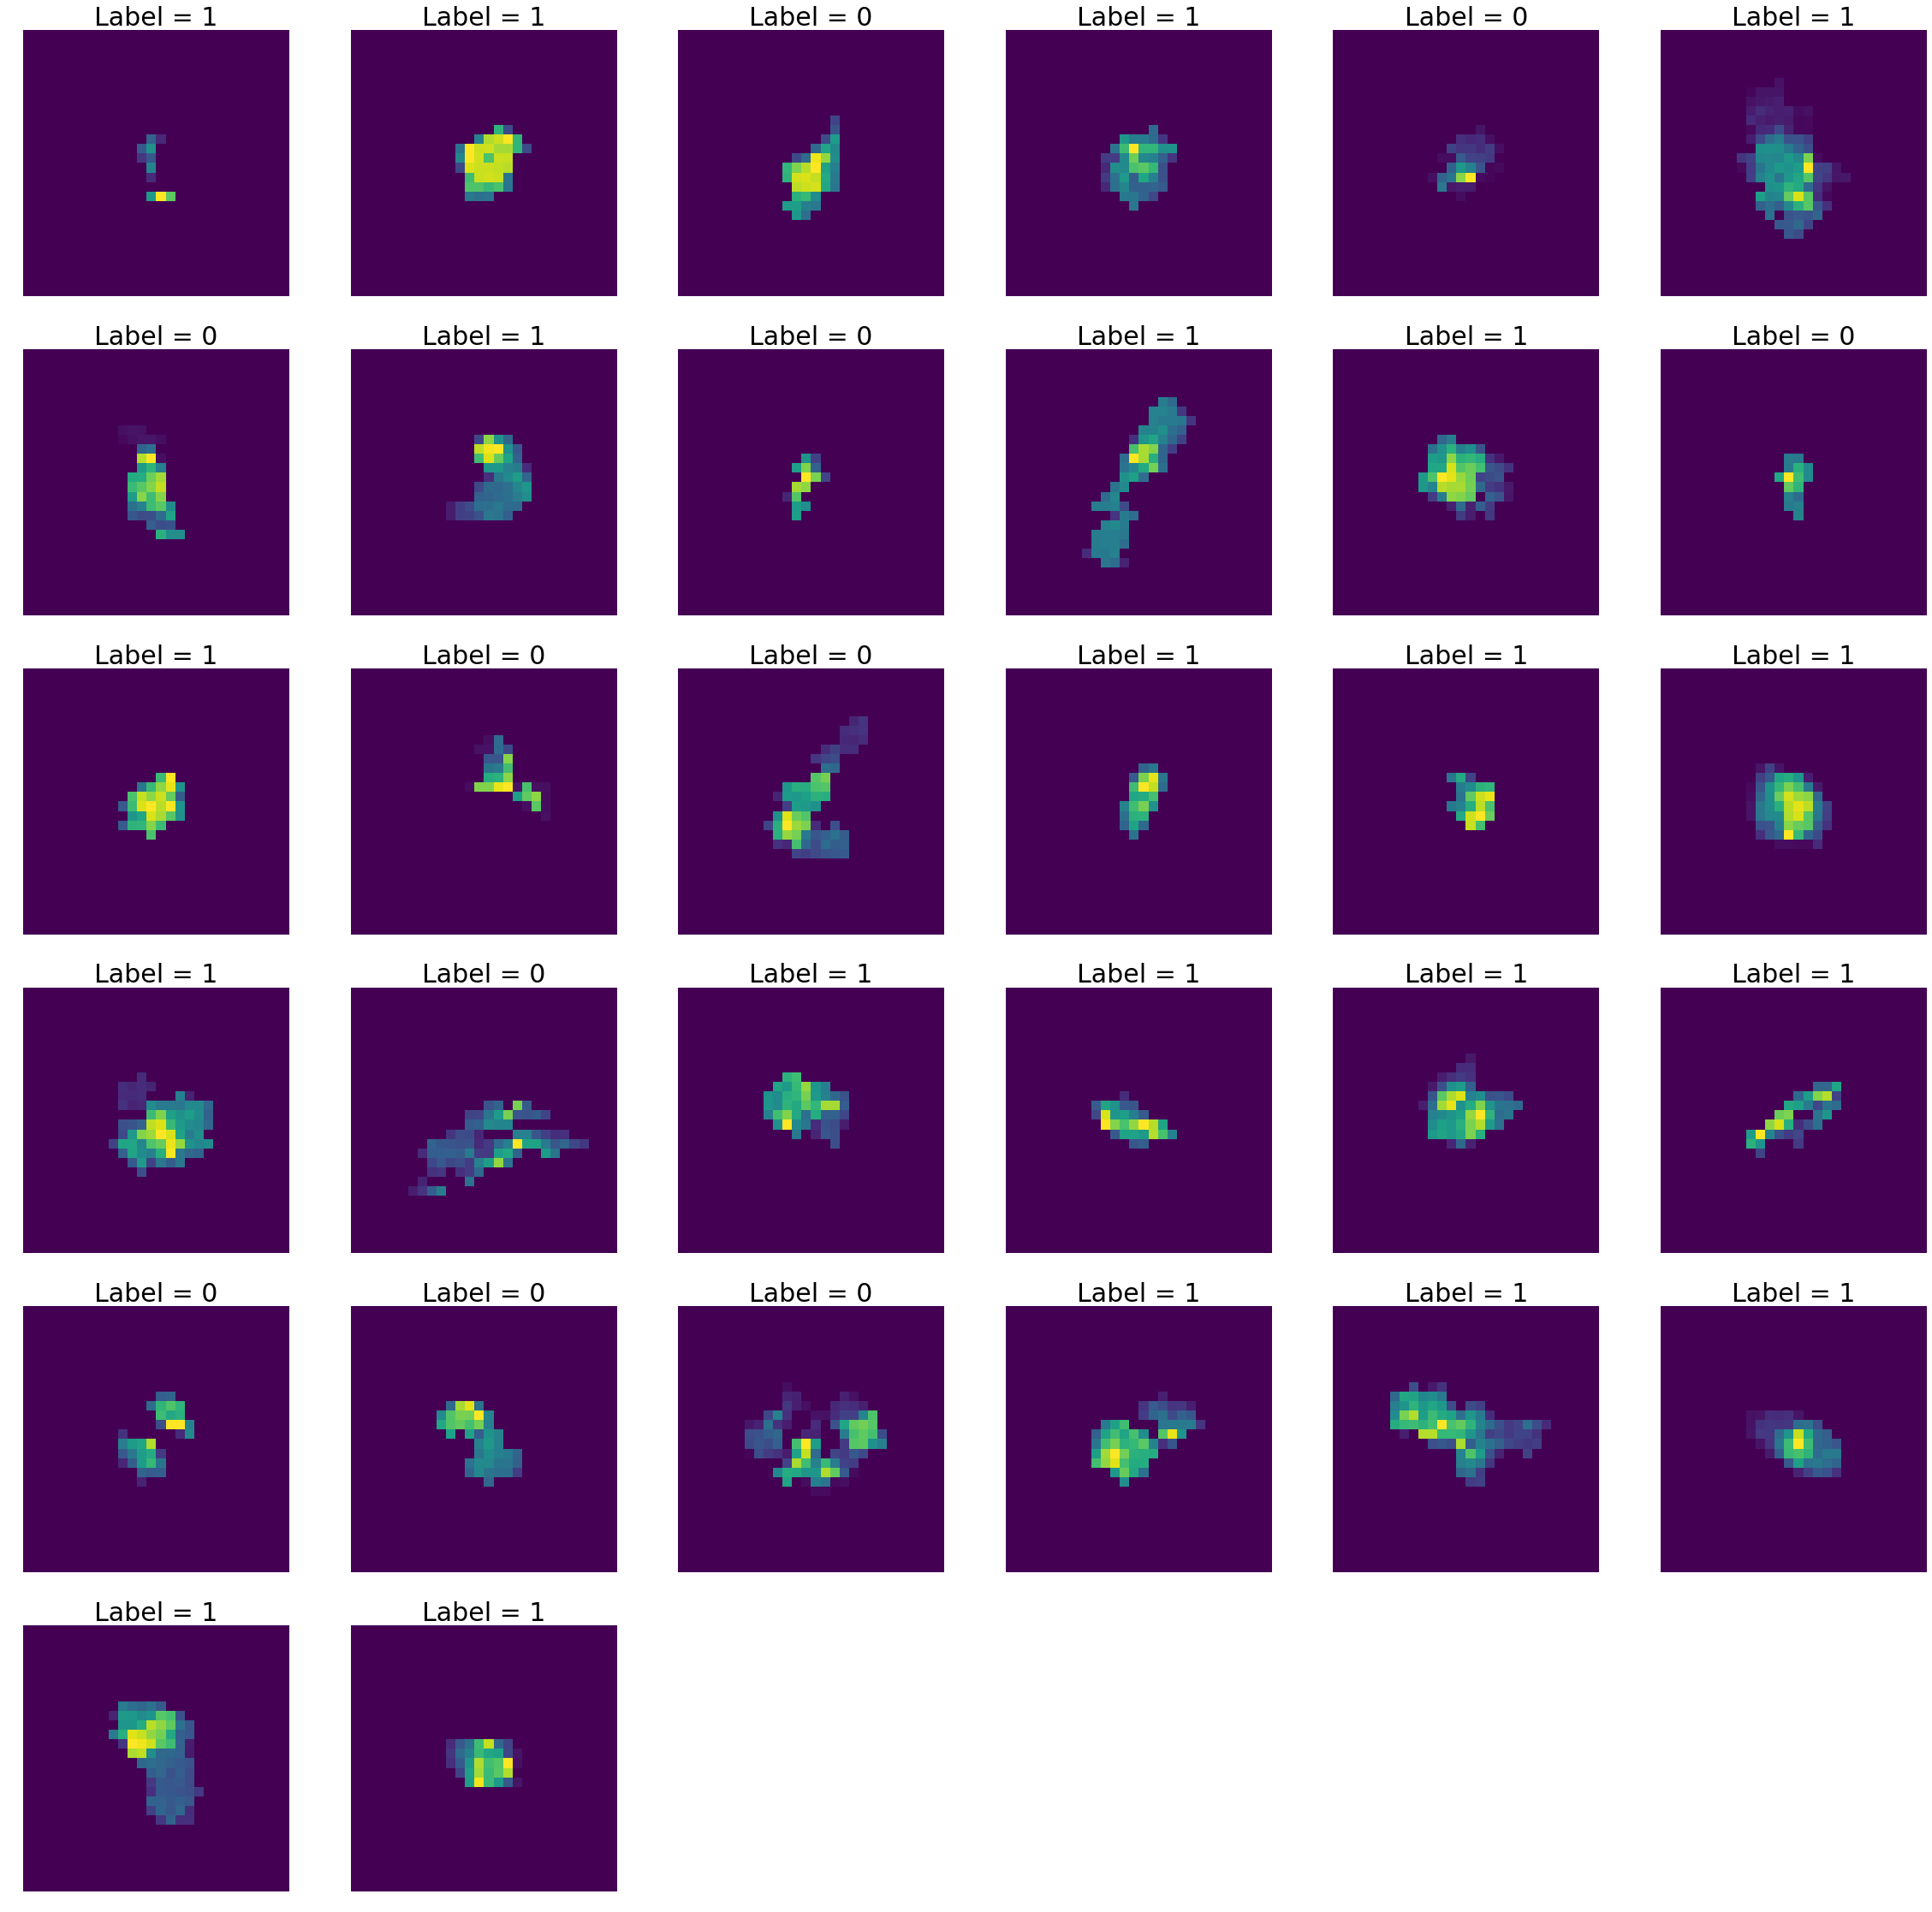

In [7]:
#Train the network
main(config, None)

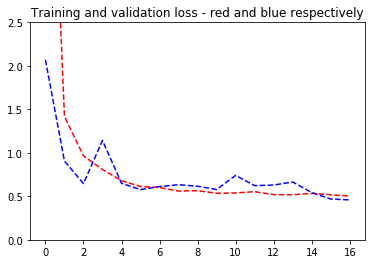

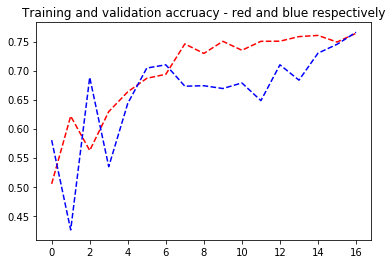

done


In [8]:
#log_dir = 'saved/runs/GroundTruth_cellData/0530_184531/'
saved_dir = 'saved/GroundTruth_cellData/0530_210510'
config_saved_filename = os.path.join(saved_dir, "config.json")
#os.system('tensorboard --logdir ' + log_dir) cannot use with google VM without paying $$$
viewTraining.graphLoss(saved_dir) #imported from utils

print('done')

In [9]:
def main2(config, resume):
    # setup data_loader instances
    data_loader = get_instance(module_data, 'data_loader_test', config)
    '''
    
    data_loader = getattr(module_data, config['data_loader']['type'])(
        config['data_loader']['args']['data_dir'],
        batch_size=1,
        shuffle=False,
        validation_split=0.0,
        training=False,
        num_workers=2
    )
    '''
    # build model architecture
    model = get_instance(module_arch, 'arch', config)
    print(model)
    print(torch.cuda.get_device_name(0))
    normalized = False

    
    # get function handles of loss and metrics
    loss_fn = getattr(module_loss, config['loss'])
    metric_fns = [getattr(module_metric, met) for met in config['metrics']]
    
    # load state dict
    checkpoint = torch.load(resume)
    state_dict = checkpoint['state_dict'] #dictionary of model parameters from saved file
    if config['n_gpu'] > 1:
        model = torch.nn.DataParallel(model)
    model.load_state_dict(state_dict) 
    
    # prepare model for testing
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval() #tells model to ignore dropout and batch normalization
    
    total_loss = 0.0
    total_metrics = torch.zeros(len(metric_fns))
    
    classes = ('class0', 'class1')
    
    with torch.no_grad(): #speed up calculations, unable to perform back propogation
        for i, (data, target) in enumerate(tqdm(data_loader)): #tqdm is a progress bar
            data, target = data.to(device), target.to(device)
            output = model(data)
            #
            # save sample images, or do something with output here
            #
            
            
            if i < 5:
                util.visualizationOutGray(data, output, target, classes, normalized)
                
                
            # computing loss, metrics on test set
            loss = loss_fn(output, target)
            batch_size = data.shape[0]
            total_loss += loss.item() * batch_size
            for i, metric in enumerate(metric_fns):
                total_metrics[i] += metric(output, target) * batch_size
        
        plt.show()
                      
    n_samples = len(data_loader.sampler)
    print("num samples = " + str(n_samples))
    log = {'loss': total_loss / n_samples}
    log.update({met.__name__: total_metrics[i].item() / n_samples for i, met in enumerate(metric_fns)})
    print(log)
    print("My_metric is accuracy")
    
   

In [10]:
#saved_dir = "saved/GroundTruth_cellData/0529_191042/"
resume = os.path.join(saved_dir, "model_best.pth")

print(os.path.isdir(saved_dir))
print(os.path.exists(resume))

#config = torch.load(saved_dir + "config.json")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

True
True


  0%|          | 0/90 [00:00<?, ?it/s]

heatmapModel(
  (layer): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=12544, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linea

100%|██████████| 90/90 [00:00<00:00, 163.16it/s]


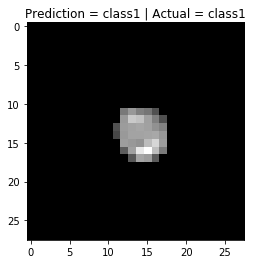

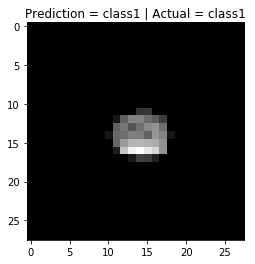

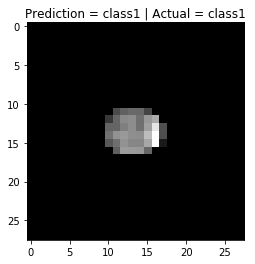

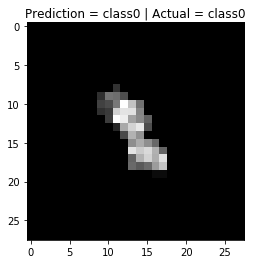

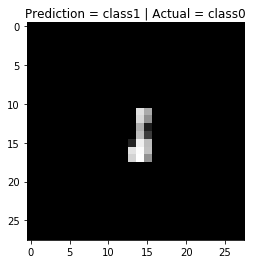

num samples = 90
{'my_metric': 0.8333333333333334, 'loss': 0.45219185849030813}
My_metric is accuracy


In [11]:
#Test
main2(config, resume)